# Comprehensive Analysis

In [1]:
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import re
import time
import seaborn as sns

from src.custom_nn import CustomNeuralNet, train_model, setup_device
from src.logistic_regression import LogisticRegression
from src.multiclass_regression import SoftmaxRegression
from src.eval import *

# C1. Hyperparameter Analysis

## 1️⃣ Prepare MNIST dataset

In [3]:
train_data = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

mean = train_data.data.float().mean() / 255.0
std = train_data.data.float().std() / 255.0
print(f"Train data mean: {mean:.4f}, std: {std:.4f}")

X_train = (train_data.data.view(-1, 28*28).float() / 255.0 - mean) / std
y_train = train_data.targets

X_test = (test_data.data.view(-1, 28*28).float() / 255.0 - mean) / std
y_test = test_data.targets

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data mean: 0.1307, std: 0.3081
Train data shape: torch.Size([60000, 784])
Train labels shape: torch.Size([60000])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000])


## 2️⃣ Learning Rate Analysis

#### Train different models

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
batch_size = 64
results_dir = os.path.join("hyperparam_results", "lr")

for lr in learning_rates:
    print(f"\n=== Training with learning rate: {lr} ===")
    
    model = CustomNeuralNet(
        sizes=[28*28, 128, 64, 10],
        activation=nn.ReLU,
        weight_init="he"
    )

    lr_dir = os.path.join(results_dir, f"lr_{lr}")
    
    train_model(
        model,
        X=X_train,
        y=y_train,
        epochs=30,
        batch=batch_size,
        lr=lr,
        val_fraction=0.3,
        patience=5,
        destination=lr_dir
    )


#### Read CSVs into dictionary

In [4]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
batch_size = 64
results_dir = os.path.join("hyperparam_results", "lr")
results = {}
for lr in learning_rates:
    csv_path = os.path.join(results_dir, f"lr_{lr}", "model1", "results.csv")
    if os.path.exists(csv_path):
        results[lr] = pd.read_csv(csv_path)
    else:
        print(f"Warning: Missing {csv_path}")

#### Figure 1: Learning Curves (Loss & Accuracy)

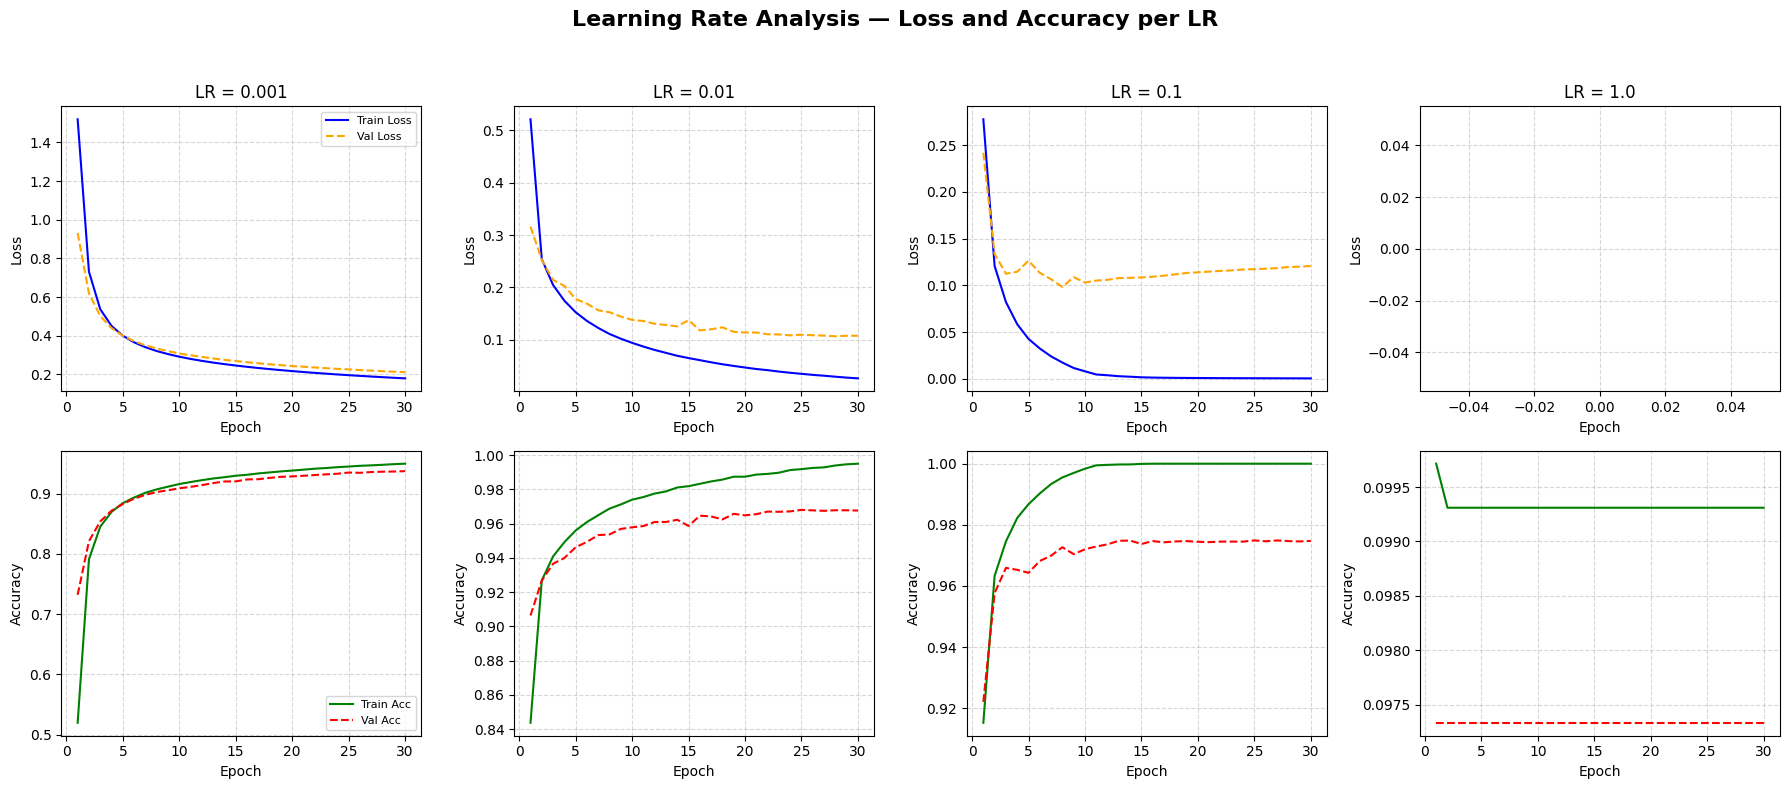

In [5]:
fig, axes = plt.subplots(2, len(results), figsize=(18, 8))
plt.suptitle("Learning Rate Analysis — Loss and Accuracy per LR", fontsize=16, fontweight="bold")

for i, (lr, df) in enumerate(results.items()):
    # Loss
    ax_loss = axes[0, i]
    ax_loss.plot(df["epoch"], df["train_loss"], label="Train Loss", color="blue")
    ax_loss.plot(df["epoch"], df["val_loss"], '--', label="Val Loss", color="orange")
    ax_loss.set_title(f"LR = {lr}")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(True, linestyle="--", alpha=0.5)
    if i == 0:
        ax_loss.legend(fontsize=8)

    # Accuracy
    ax_acc = axes[1, i]
    ax_acc.plot(df["epoch"], df["train_acc"], label="Train Acc", color="green")
    ax_acc.plot(df["epoch"], df["val_acc"], '--', label="Val Acc", color="red")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.grid(True, linestyle="--", alpha=0.5)
    if i == 0:
        ax_acc.legend(fontsize=8)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


#### Figure 2: Convergence Analysis (Speed & Stability)

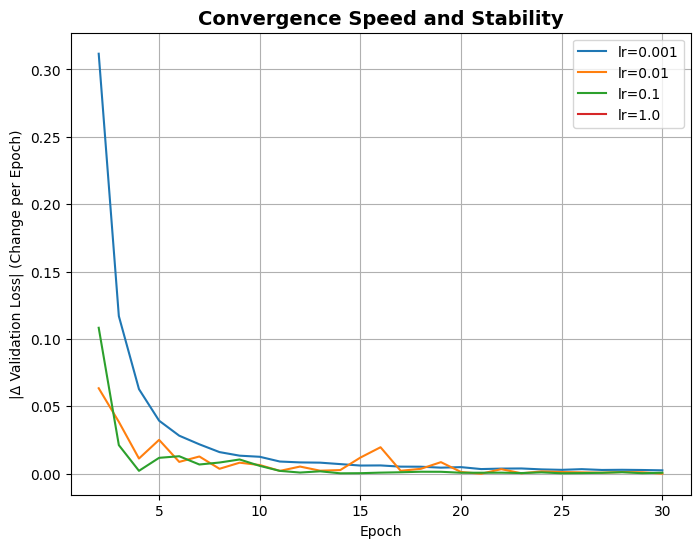

In [6]:
plt.figure(figsize=(8, 6))
plt.title("Convergence Speed and Stability", fontsize=14, fontweight="bold")

for lr, df in results.items():
    # Compute per-epoch change in val_loss to estimate convergence rate
    val_loss_change = df["val_loss"].diff().abs()
    plt.plot(df["epoch"], val_loss_change, label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("|Δ Validation Loss| (Change per Epoch)")
plt.legend()
plt.grid(True)
plt.show()

#### Analysis and Comparing Models

In [7]:
summary = []
for lr, df in results.items():
    best_idx = df["val_acc"].idxmax()
    best_row = df.iloc[best_idx]

    summary.append({
        "Learning Rate": lr,
        "Best Epoch": best_idx + 1,
        "Best Train Loss": best_row["train_loss"],
        "Best Val Loss": best_row["val_loss"],
        "Best Train Acc": best_row["train_acc"],
        "Best Val Acc": best_row["val_acc"],
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="Best Val Acc", ascending=False).reset_index(drop=True)

# Highlight best row
best_row = summary_df.iloc[0]
best_lr = best_row["Learning Rate"]

print("=== Learning Rate Performance Summary ===")
display(
    summary_df.style
        .highlight_max(subset=["Best Val Acc"], color="green")
        .format(precision=4)
        .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
        .hide(axis="index")
)


=== Learning Rate Performance Summary ===


Learning Rate,Best Epoch,Best Train Loss,Best Val Loss,Best Train Acc,Best Val Acc
0.1000,25,0.0005,0.1173,1.0000,0.9749
0.0100,25,0.0351,0.1098,0.9919,0.9681
0.0010,30,0.1800,0.2119,0.9496,0.9373
1.0000,1,nan,nan,0.0997,0.0973


## 2️⃣ Batch Size Analysis

#### Train different models

In [ ]:
batch_sizes = [8, 16, 32, 64, 128, 256]
results_dir = os.path.join("hyperparam_results", "batch_size")

for batch in batch_sizes:
    print(f"\n=== Training with batch size: {batch} ===")
    
    model = CustomNeuralNet(
        sizes=[28*28, 128, 64, 10],
        activation=nn.ReLU,
        weight_init="he"
    )
    
    batch_dir = os.path.join(results_dir, f"batch_{batch}")

    train_model(
        model,
        X=X_train,
        y=y_train,
        epochs=30,
        batch=batch,
        lr=0.01,
        val_fraction=0.3,
        patience=5,
        destination=batch_dir
    )


#### Read CSVs into dictionary

In [8]:
batch_sizes = [8, 16, 32, 64, 128, 256]
results_dir = os.path.join("hyperparam_results", "batch_size")
results = {}
for bs in batch_sizes:
    path = os.path.join(results_dir, f"batch_{bs}", "model1", "results.csv")
    if os.path.exists(path):
        results[bs] = pd.read_csv(path)
    else:
        print(f"Warning: Missing {path}")

#### Plot learning curves for all batch sizes

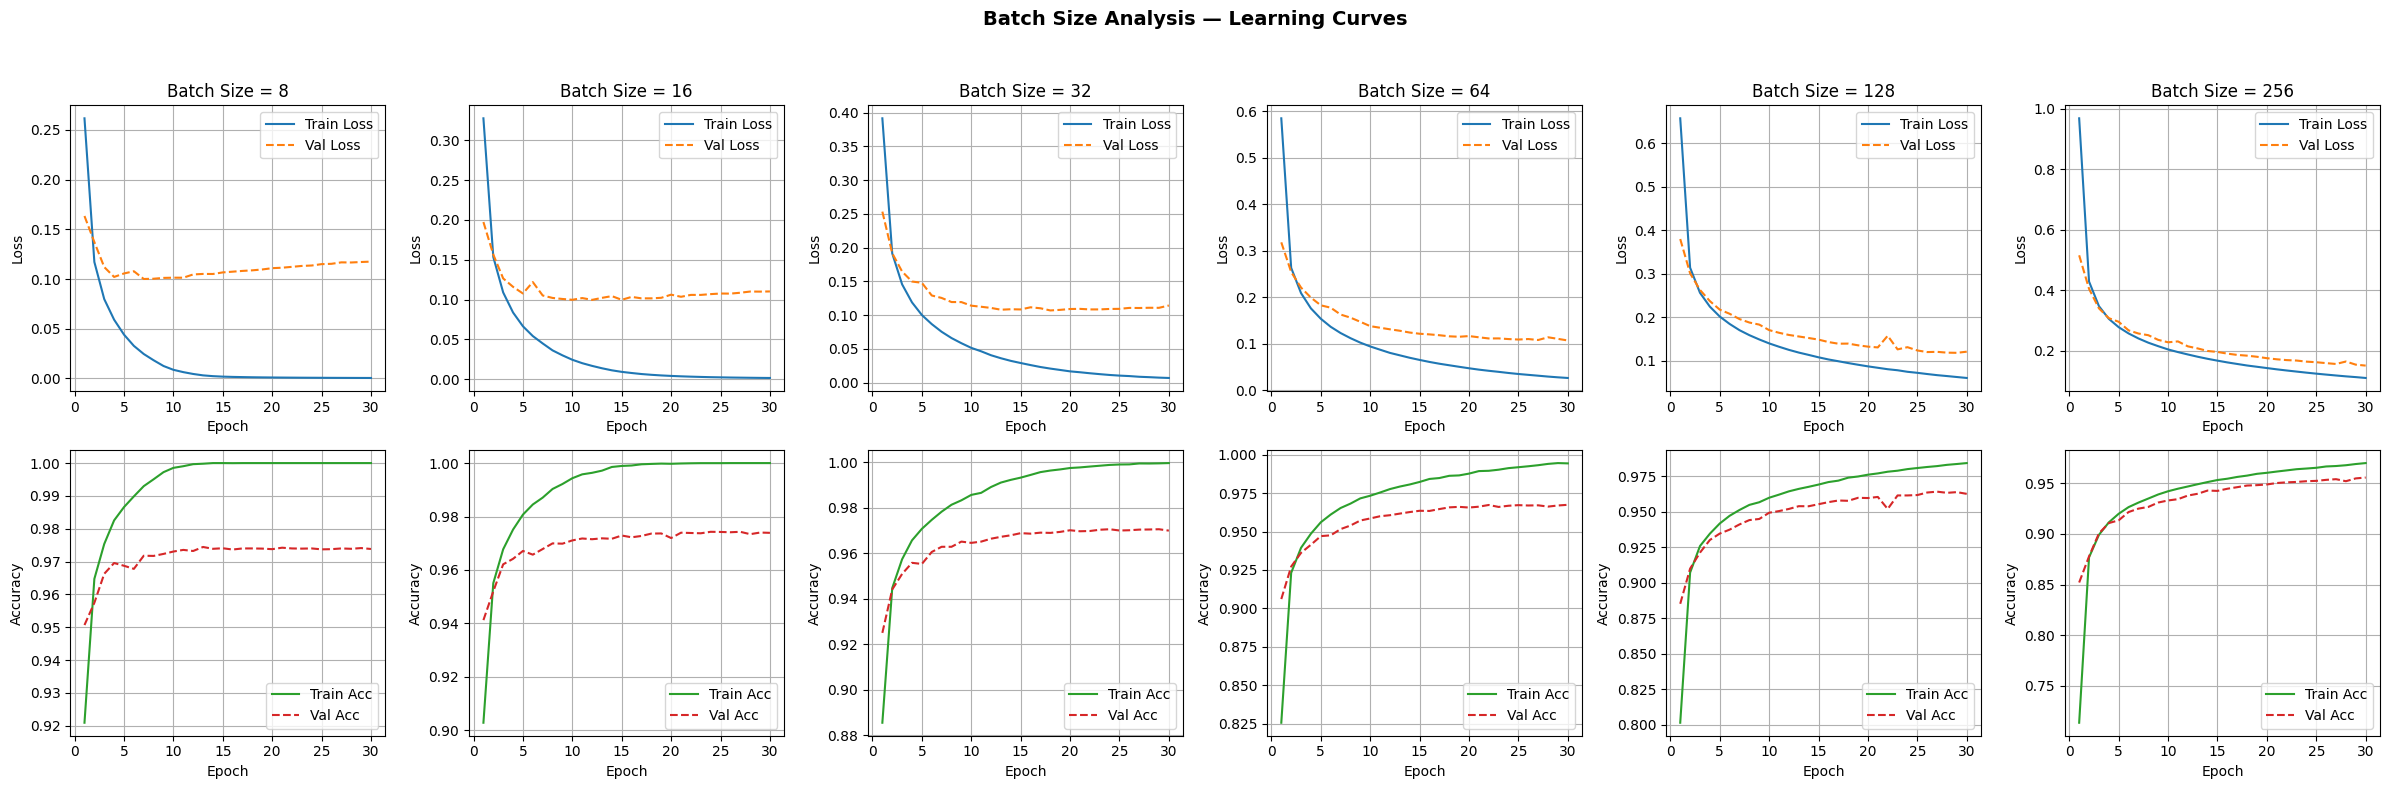

In [9]:
n = len(results)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
plt.suptitle("Batch Size Analysis — Learning Curves", fontsize=14, fontweight="bold")

for i, (bs, df) in enumerate(results.items()):
    # Loss
    axes[0][i].plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:blue")
    axes[0][i].plot(df["epoch"], df["val_loss"], label="Val Loss", color="tab:orange", linestyle="--")
    axes[0][i].set_title(f"Batch Size = {bs}")
    axes[0][i].set_xlabel("Epoch")
    axes[0][i].set_ylabel("Loss")
    axes[0][i].grid(True)
    axes[0][i].legend()

    # Accuracy
    axes[1][i].plot(df["epoch"], df["train_acc"], label="Train Acc", color="tab:green")
    axes[1][i].plot(df["epoch"], df["val_acc"], label="Val Acc", color="tab:red", linestyle="--")
    axes[1][i].set_xlabel("Epoch")
    axes[1][i].set_ylabel("Accuracy")
    axes[1][i].grid(True)
    axes[1][i].legend()

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


#### Convergence analysis and comparing models

In [10]:
summary = []
for bs, df in results.items():
    best_idx = df["val_acc"].idxmax()
    best_row = df.iloc[best_idx]

    summary.append({
        "Batch Size": bs,
        "Best Epoch": best_idx + 1,
        "Best Train Loss": best_row["train_loss"],
        "Best Val Loss": best_row["val_loss"],
        "Best Train Acc": best_row["train_acc"],
        "Best Val Acc": best_row["val_acc"],
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="Best Val Acc", ascending=False).reset_index(drop=True)

print("=== Batch Size Performance Summary ===")
display(
    summary_df.style
        .highlight_max(subset=["Best Val Acc"], color="green")
        .format(precision=4)
        .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
        .hide(axis="index")
)

=== Batch Size Performance Summary ===


Batch Size,Best Epoch,Best Train Loss,Best Val Loss,Best Train Acc,Best Val Acc
8,13,0.0031,0.1051,0.9998,0.9744
16,24,0.0027,0.1069,1.0000,0.9743
32,24,0.0115,0.1093,0.9989,0.9706
64,30,0.0267,0.1073,0.9944,0.9674
128,27,0.0674,0.1209,0.9820,0.9640
256,30,0.1095,0.1504,0.9700,0.9557


## 3️⃣ Architecture Analysis

#### Train different models

In [ ]:
hidden_layers_list = [1, 2, 3, 4, 5]
neurons_list = [64, 128, 256, 512]
results_dir = os.path.join("hyperparam_results", "arch")

for n_layers in hidden_layers_list:
    for n_neurons in neurons_list:
        sizes = [28*28] + [n_neurons]*n_layers + [10]
        print(f"\n=== Architecture: {sizes} ===")
        
        model = CustomNeuralNet(
            sizes=sizes,
            activation=nn.ReLU,
            weight_init="he"
        )
        
        arch_dir = os.path.join(results_dir, f"arch_{n_layers}L_{n_neurons}N")
        
        train_model(
            model,
            X=X_train,
            y=y_train,
            epochs=30,
            batch=64,
            lr=0.01,
            val_fraction=0.3,
            patience=5,
            destination=arch_dir
        )


#### Read CSVs into dictionary

In [11]:
def extract_numbers(folder_name):
    nums = re.findall(r'\d+', folder_name)
    return tuple(map(int, nums)) if nums else (0,)

hidden_layers_list = [1, 2, 3, 4, 5]
neurons_list = [64, 128, 256, 512]
results_dir = os.path.join("hyperparam_results", "arch")
results = {}
for folder in sorted(os.listdir(results_dir), key=lambda f: extract_numbers(f)):
    path = os.path.join(results_dir, folder, "model1", "results.csv")
    if os.path.exists(path):
        results[folder] = pd.read_csv(path)
    else:
        print(f"Warning: Missing {path}")

#### Plot learning curves for all architectures

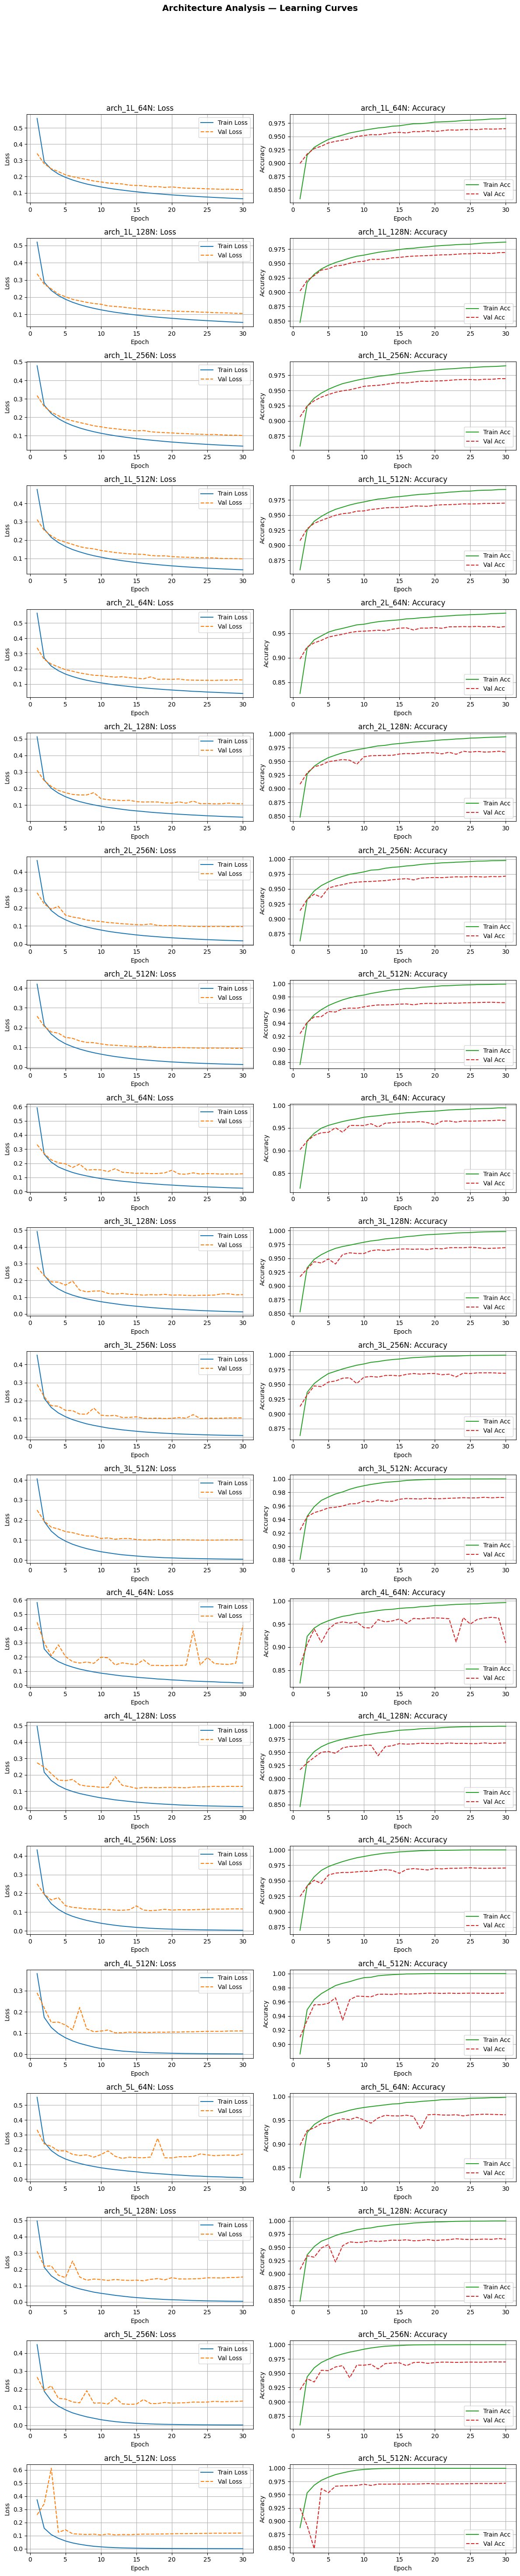

In [12]:
n = len(results)
fig, axes = plt.subplots(n, 2, figsize=(12, 3*n))
plt.suptitle("Architecture Analysis — Learning Curves", fontsize=14, fontweight="bold")

if n == 1:
    axes = [axes]

for i, (arch, df) in enumerate(results.items()):
    # --- Loss ---
    axes[i][0].plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:blue")
    axes[i][0].plot(df["epoch"], df["val_loss"], label="Val Loss", color="tab:orange", linestyle="--")
    axes[i][0].set_title(f"{arch}: Loss")
    axes[i][0].set_xlabel("Epoch")
    axes[i][0].set_ylabel("Loss")
    axes[i][0].grid(True)
    axes[i][0].legend()

    # --- Accuracy ---
    axes[i][1].plot(df["epoch"], df["train_acc"], label="Train Acc", color="tab:green")
    axes[i][1].plot(df["epoch"], df["val_acc"], label="Val Acc", color="tab:red", linestyle="--")
    axes[i][1].set_title(f"{arch}: Accuracy")
    axes[i][1].set_xlabel("Epoch")
    axes[i][1].set_ylabel("Accuracy")
    axes[i][1].grid(True)
    axes[i][1].legend()

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

#### Analysis and Comparing Models

In [ ]:
summary = []
for arch, df in results.items():
    best_idx = df["val_acc"].idxmax()
    best_row = df.iloc[best_idx]

    summary.append({
        "Architecture": arch,
        "Best Epoch": int(best_row["epoch"]),
        "Best Train Acc": best_row["train_acc"],
        "Best Val Acc": best_row["val_acc"],
        "Train Loss": best_row["train_loss"],
        "Val Loss": best_row["val_loss"]
    })

summary_df = pd.DataFrame(summary).reset_index(drop=True)

best_idx = summary_df["Best Val Acc"].idxmax()

def highlight_best_row(row):
    color = 'blue' if row.name == best_idx else ''
    return ['background-color: {}'.format(color)] * len(row)

display(
    summary_df.style
        .apply(highlight_best_row, axis=1)
        .highlight_max(subset=["Best Val Acc"], color="green")
        .format(precision=4)
        .hide(axis="index")
)


Architecture,Best Epoch,Best Train Acc,Best Val Acc,Train Loss,Val Loss
arch_1L_64N,30,0.9838,0.9646,0.0634,0.1197
arch_1L_128N,30,0.9872,0.9691,0.0525,0.1050
arch_1L_256N,29,0.9899,0.9696,0.0452,0.1025
arch_1L_512N,30,0.9925,0.9698,0.0374,0.0975
arch_2L_64N,26,0.9882,0.9639,0.0451,0.1233
arch_2L_128N,24,0.9914,0.9684,0.0375,0.1084
arch_2L_256N,30,0.9978,0.9715,0.0174,0.0957
arch_2L_512N,28,0.9988,0.9717,0.0144,0.0957
arch_3L_64N,29,0.9946,0.9674,0.0251,0.1232
arch_3L_128N,25,0.9965,0.9699,0.0191,0.1120


## 4️⃣ Train Best Neural Network

Based on analysis, best neural neural network with lr=0.1 batch_size=8 arch=3 hidden layers with 512 neuron

In [ ]:
sizes = [28*28] + [513]*3 + [10]
lr=0.1
batch_sz=8

model = CustomNeuralNet(
        sizes=sizes,
        activation=nn.ReLU,
        weight_init="he"
    )
    
dirct = os.path.join("classification_models", "nn")

train_model(
    model,
    X=X_train,
    y=y_train,
    epochs=30,
    batch=batch_sz,
    lr=lr,
    val_fraction=0.3,
    patience=5,
    destination=dirct
)


# C2. Model Comparison
Compare logistic regression, softmax regression, and best neural network

## 1️⃣ Prepare MNIST test dataset

In [2]:
train_data = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

mean = train_data.data.float().mean() / 255.0
std = train_data.data.float().std() / 255.0

X_test = (test_data.data.view(-1, 28*28).float() / 255.0 - mean) / std
y_test = test_data.targets

# Binary model: 0 vs 1 classification
binary_indices = (y_test == 0) | (y_test == 1)
X_test_binary = X_test[binary_indices]
y_test_binary = y_test[binary_indices]


print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print(f"\nBinary test set size: {len(y_test_binary)} samples")
print(f"Multiclass test set size: {len(y_test)} samples")

Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000])

Binary test set size: 2115 samples
Multiclass test set size: 10000 samples


## 2️⃣ Load Models

In [3]:
bin_model_path = os.path.join("classification_models", "binary_logistic_regression_model.pth")
multi_model_path = os.path.join("classification_models", "multi_class_softmax_regression_model.pth")
nn_model_path = os.path.join("classification_models", "nn", "model1", "weights", "best.pt")

In [4]:
sizes = [28*28] + [513]*3 + [10]
device = setup_device()

# Load binary class model
try:
    binary_model = BinaryLogisticRegression()
    binary_checkpoint = torch.load(bin_model_path, map_location=device)
    binary_model.load_state_dict(binary_checkpoint)
    binary_model.to(device)
    binary_model.eval()
    print("Binary model loaded successfully")
except Exception as e:
    print(f"Error loading binary model: {e}")
    binary_model = None

# Load multiclass model
try:
    multiclass_model = MulticlassLogisticRegression()
    multiclass_checkpoint = torch.load(multi_model_path, map_location=device)
    multiclass_model.load_state_dict(multiclass_checkpoint)
    multiclass_model.to(device)
    multiclass_model.eval()
    print("Multiclass model loaded successfully")
except Exception as e:
    print(f"Error loading multiclass model: {e}")
    multiclass_model = None

# Load best neural network model
try:
    best_nn_model = CustomNeuralNet(
        sizes=sizes,
        activation=nn.ReLU,
        weight_init="he"
    )
    nn_checkpoint = torch.load(nn_model_path, map_location=device)
    best_nn_model.load_state_dict(nn_checkpoint['model_state'])
    best_nn_model.to(device)
    best_nn_model.eval()
    print("Neural Network model loaded successfully")
except Exception as e:
    print(f"Error loading NN model: {e}")
    best_nn_model = None

Utilizing device: cuda:0
Binary model loaded successfully
Multiclass model loaded successfully
Neural Network model loaded successfully


C:\Users\Youssef\AppData\Local\Temp\ipykernel_788\772945862.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  binary_checkpoint = torch.load(bin_model_path, map_location=d

## 3️⃣ Evaluate Models

#### Run evaluation

In [5]:
results_comparison = {}

Binary Model

In [6]:
start_time = time.time()
acc, loss, preds, labels = evaluate_model(
    binary_model, X_test_binary, y_test_binary, device, model_type='binary'
)
eval_time = time.time() - start_time

num_params = sum(p.numel() for p in binary_model.parameters())

results_comparison['Binary Logistic Regression'] = {
    'accuracy': acc,
    'loss': loss,
    'num_params': num_params,
    'eval_time': eval_time,
    'predictions': preds,
    'labels': labels,
    'test_size': len(y_test_binary),
    'task': 'Binary (0 vs 1)'
}

Multi-Class Model

In [7]:
start_time = time.time()
acc, loss, preds, labels = evaluate_model(
    multiclass_model, X_test, y_test, device, model_type='multiclass'
)
eval_time = time.time() - start_time

num_params = sum(p.numel() for p in multiclass_model.parameters())

results_comparison['Softmax Regression'] = {
    'accuracy': acc,
    'loss': loss,
    'num_params': num_params,
    'eval_time': eval_time,
    'predictions': preds,
    'labels': labels,
    'test_size': len(y_test),
    'task': 'Multiclass (10 digits)'
}

Neural-Network Model

In [8]:
start_time = time.time()
acc, loss, preds, labels = evaluate_model(
    best_nn_model, X_test, y_test, device, model_type='multiclass'
)
eval_time = time.time() - start_time

num_params = sum(p.numel() for p in best_nn_model.parameters())

results_comparison['Best Neural Network'] = {
    'accuracy': acc,
    'loss': loss,
    'num_params': num_params,
    'eval_time': eval_time,
    'predictions': preds,
    'labels': labels,
    'test_size': len(y_test),
    'task': 'Multiclass (10 digits)'
}

#### Performance Summary Table

In [9]:
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_data = []
for name, data in results_comparison.items():
    # Calculate computational complexity (FLOPs approximation)
    if 'Binary' in name:
        flops = 784 * 1 * 2  # Input * Output * (mult + add)
        complexity = "Very Low"
    elif 'Softmax' in name:
        flops = 784 * 10 * 2
        complexity = "Low"
    else:
        flops = 0
        prev = 784
        for i in range(1, len(data.get('architecture', []))-1):
            size = data['architecture'][i]
            flops += prev * size * 2
            prev = size
        flops += prev * 10 * 2

        if data['num_params'] < 100000:
            complexity = "Low"
        elif data['num_params'] < 200000:
            complexity = "Medium"
        else:
            complexity = "High"

    summary_data.append({
        'Model': name,
        'Task': data['task'],
        'Parameters': f"{data['num_params']:,}",
        'FLOPs': f"{flops:,}",
        'Complexity': complexity,
        'Test Acc (%)': f"{data['accuracy']:.2f}",
        'Test Loss': f"{data['loss']:.4f}",
        'Eval Time (s)': f"{data['eval_time']:.4f}",
        'Speed (samples/s)': f"{data['test_size']/data['eval_time']:.0f}"
    })

comparison_df = pd.DataFrame(summary_data)

display(
    comparison_df.style
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'left')]}
        ])
        .hide(axis="index")
)


COMPREHENSIVE PERFORMANCE SUMMARY TABLE


Model,Task,Parameters,FLOPs,Complexity,Test Acc (%),Test Loss,Eval Time (s),Speed (samples/s)
Binary Logistic Regression,Binary (0 vs 1),785,"1,568",Very Low,99.81,0.0059,0.2250,9401
Softmax Regression,Multiclass (10 digits),"7,850","15,680",Low,88.64,0.6726,0.0653,153245
Best Neural Network,Multiclass (10 digits),"935,209","15,680",High,96.96,0.1489,0.1237,80869


#### Performance Visualization

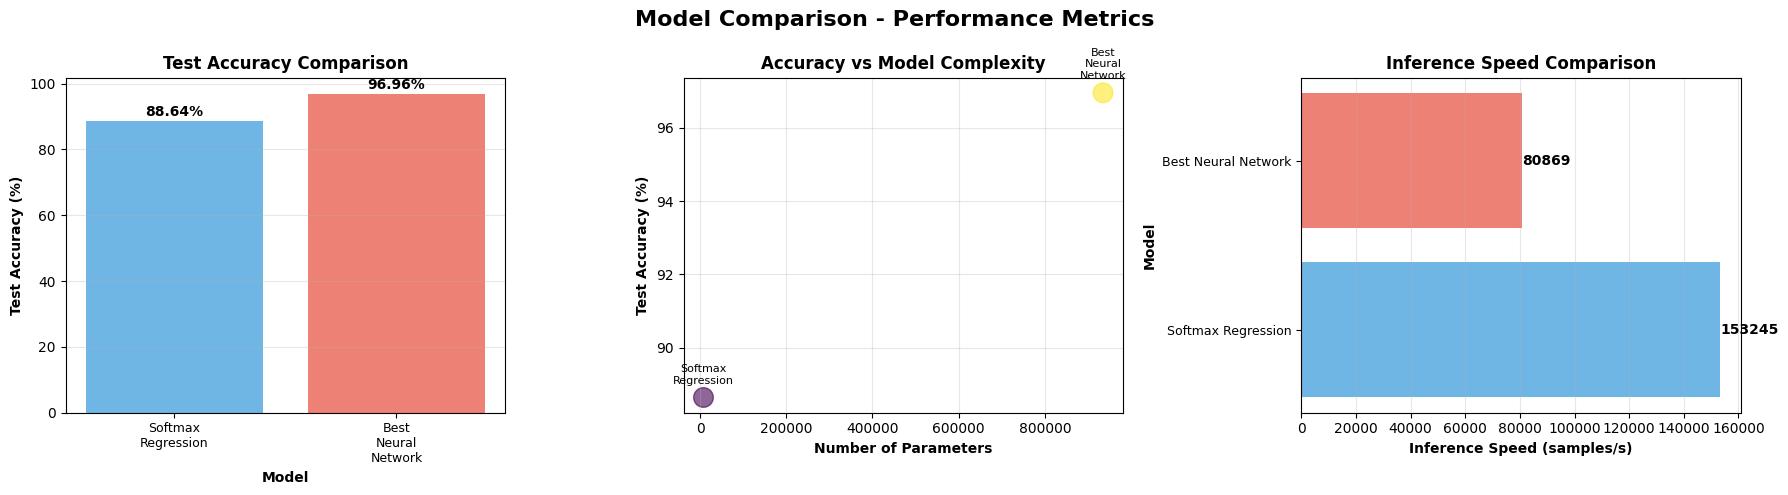

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Comparison - Performance Metrics', fontsize=16, fontweight='bold')

model_names = list(results_comparison.keys())
# Only multiclass models 
multiclass_names = [name for name in model_names if 'Binary' not in name]

if len(multiclass_names) >= 2:
    multiclass_accs = [results_comparison[m]['accuracy'] for m in multiclass_names]
    multiclass_params = [results_comparison[m]['num_params'] for m in multiclass_names]
    multiclass_times = [results_comparison[m]['eval_time'] for m in multiclass_names]

    # Plot 1: Accuracy Comparison
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = axes[0].bar(range(len(multiclass_names)), multiclass_accs, color=colors[:len(multiclass_names)], alpha=0.7)
    axes[0].set_xlabel('Model', fontweight='bold')
    axes[0].set_ylabel('Test Accuracy (%)', fontweight='bold')
    axes[0].set_title('Test Accuracy Comparison', fontweight='bold')
    axes[0].set_xticks(range(len(multiclass_names)))
    axes[0].set_xticklabels([name.replace(' ', '\n') for name in multiclass_names], fontsize=9)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, multiclass_accs)):
        axes[0].text(bar.get_x() + bar.get_width()/2., acc + 0.5,
                    f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Accuracy vs Parameters
    axes[1].scatter(multiclass_params, multiclass_accs, s=200, alpha=0.6,
                   c=range(len(multiclass_names)), cmap='viridis')

    for i, name in enumerate(multiclass_names):
        axes[1].annotate(name.replace(' ', '\n'),
                        (multiclass_params[i], multiclass_accs[i]),
                        fontsize=8, ha='center', xytext=(0, 10),
                        textcoords='offset points')

    axes[1].set_xlabel('Number of Parameters', fontweight='bold')
    axes[1].set_ylabel('Test Accuracy (%)', fontweight='bold')
    axes[1].set_title('Accuracy vs Model Complexity', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Speed Comparison (Samples per second)
    speeds = [results_comparison[m]['test_size']/results_comparison[m]['eval_time']
              for m in multiclass_names]
    bars = axes[2].barh(range(len(multiclass_names)), speeds,
                       color=colors[:len(multiclass_names)], alpha=0.7)
    axes[2].set_ylabel('Model', fontweight='bold')
    axes[2].set_xlabel('Inference Speed (samples/s)', fontweight='bold')
    axes[2].set_title('Inference Speed Comparison', fontweight='bold')
    axes[2].set_yticks(range(len(multiclass_names)))
    axes[2].set_yticklabels(multiclass_names, fontsize=9)
    axes[2].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, speed) in enumerate(zip(bars, speeds)):
        axes[2].text(speed + 100, bar.get_y() + bar.get_height()/2.,
                    f'{speed:.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


#### Confusion Matrix for Best Model


DETAILED EVALUATION: Best Neural Network


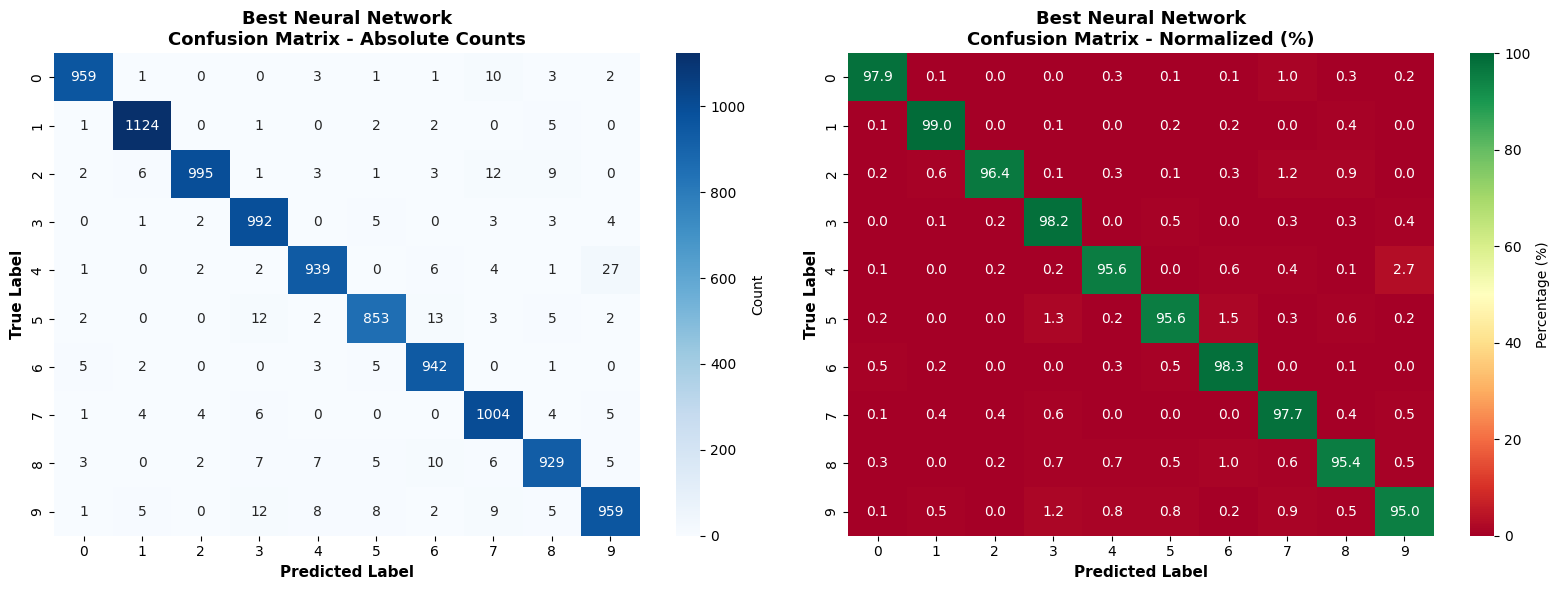

In [11]:
best_model_name = max(
    [k for k in results_comparison.keys() if 'Binary' not in k],
    key=lambda x: results_comparison[x]['accuracy']
)
best_data = results_comparison[best_model_name]

print(f"\n{'='*80}")
print(f"DETAILED EVALUATION: {best_model_name}")
print(f"{'='*80}")

# Confusion Matrix
cm = confusion_matrix(best_data['labels'], best_data['predictions'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
ax1.set_title(f'{best_model_name}\nConfusion Matrix - Absolute Counts',
             fontsize=13, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

# Normalized percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax2.set_title(f'{best_model_name}\nConfusion Matrix - Normalized (%)',
             fontsize=13, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

#### Classification Report

In [12]:
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(best_data['labels'], best_data['predictions'],
                          digits=4, target_names=[str(i) for i in range(10)]))


--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9836    0.9786    0.9811       980
           1     0.9834    0.9903    0.9868      1135
           2     0.9900    0.9641    0.9769      1032
           3     0.9603    0.9822    0.9711      1010
           4     0.9731    0.9562    0.9646       982
           5     0.9693    0.9563    0.9628       892
           6     0.9622    0.9833    0.9726       958
           7     0.9553    0.9767    0.9658      1028
           8     0.9627    0.9538    0.9582       974
           9     0.9552    0.9504    0.9528      1009

    accuracy                         0.9696     10000
   macro avg     0.9695    0.9692    0.9693     10000
weighted avg     0.9697    0.9696    0.9696     10000



#### Misclassification Analysis

In [13]:
print("\n" + "="*80)
print("MISCLASSIFICATION ANALYSIS")
print("="*80)

preds = best_data['predictions']
labels = best_data['labels']

misclassified_indices = np.where(preds != labels)[0]
total_errors = len(misclassified_indices)

print(f"\nTotal Misclassified: {total_errors} out of {len(labels)} ({100*total_errors/len(labels):.2f}%)")

# Per-class error analysis
print("\n" + "-"*80)
print("PER-CLASS ERROR ANALYSIS")
print("-"*80)
print(f"{'Digit':<8} {'Total':<8} {'Correct':<8} {'Errors':<8} {'Accuracy':<12} {'Error Rate':<12}")
print("-"*80)

class_metrics = []
for digit in range(10):
    digit_mask = labels == digit
    digit_total = np.sum(digit_mask)
    digit_correct = np.sum((labels == digit) & (preds == digit))
    digit_errors = digit_total - digit_correct
    digit_acc = 100 * digit_correct / digit_total if digit_total > 0 else 0
    error_rate = 100 * digit_errors / digit_total if digit_total > 0 else 0

    print(f"{digit:<8} {digit_total:<8} {digit_correct:<8} {digit_errors:<8} "
          f"{digit_acc:<12.2f} {error_rate:<12.2f}")

    class_metrics.append({
        'digit': digit,
        'total': digit_total,
        'errors': digit_errors,
        'error_rate': error_rate
    })

# Most confused pairs
print("\n" + "-"*80)
print("MOST COMMON MISCLASSIFICATION PAIRS")
print("-"*80)

confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"{'True Label':<12} {'Predicted As':<15} {'Count':<10} {'% of True Class':<15}")
print("-"*80)
for true_label, pred_label, count in confusion_pairs[:15]:
    total_true = np.sum(labels == true_label)
    percentage = 100 * count / total_true
    print(f"{true_label:<12} {pred_label:<15} {count:<10} {percentage:<15.2f}%")



MISCLASSIFICATION ANALYSIS

Total Misclassified: 304 out of 10000 (3.04%)

--------------------------------------------------------------------------------
PER-CLASS ERROR ANALYSIS
--------------------------------------------------------------------------------
Digit    Total    Correct  Errors   Accuracy     Error Rate  
--------------------------------------------------------------------------------
0        980      959      21       97.86        2.14        
1        1135     1124     11       99.03        0.97        
2        1032     995      37       96.41        3.59        
3        1010     992      18       98.22        1.78        
4        982      939      43       95.62        4.38        
5        892      853      39       95.63        4.37        
6        958      942      16       98.33        1.67        
7        1028     1004     24       97.67        2.33        
8        974      929      45       95.38        4.62        
9        1009     959      50       